In [1]:
import sys
sys.path.append("..")

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import itertools

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import torch
import torchvision
import umap
import yaml

import datasets
from datasets import preprocessing
from utils import main_utils

/Users/michaloleszak/Documents/AVID-CMA/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load model & data

In [2]:
class Args:
    rank = -1
    quiet = False

args = Args()

cfg = yaml.safe_load(open("../configs/main/avid-cma/kinetics/InstX-N1024-PosW-N64-Top32.yaml"))
logger, tb_writter, model_dir = main_utils.prep_environment(args, cfg)

cfg['model']['args']['checkpoint'] = '../checkpoints/AVID-CMA/kinetics/Cross-N1024/checkpoint.pth.tar'
model = main_utils.build_model(cfg['model'], logger)
state_dict = torch.load("../checkpoints/AVID-CMA/kinetics/Cross-N1024/checkpoint.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict({k.replace('module.', ''): state_dict['model'][k] for k in state_dict['model']})
model.eval()

AV_Wrapper(
  (video_model): R2Plus1D(
    (conv1): Sequential(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    )
    (conv2x): Sequential(
      (0): BasicR2P1DBlock(
        (spt_conv1): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
        (spt_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (tmp_conv1): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        (tmp_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (spt_conv2): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
        (spt_bn2): BatchNo

In [3]:
video_transform = preprocessing.VideoPrep_MSC_CJ(
            crop=(224, 224),
            augment=False,
            num_frames=0.5 * 16,
            pad_missing=True,
        )
audio_transform = [
    preprocessing.AudioPrep(
        trim_pad=True,
        duration=2,
        augment=False,
        missing_as_zero=True),
    preprocessing.LogSpectrogram(
        24000,
        n_fft=512,
        hop_size=1. / 100,
        normalize=True)
]

In [4]:
dataset = datasets.Kinetics(
    subset="val",
    return_video=True,
    video_clip_duration=0.5,
    video_fps=16,
    video_transform=video_transform,
    return_audio=True,
    audio_clip_duration=2,
    audio_fps=24000,
    audio_fps_out=64,
    audio_transform=audio_transform,
    max_offsync_augm=0,
    return_labels=True,
    return_index=True,
    mode='clip',
    clips_per_video=10,
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    pin_memory=True,
    sampler=None
)
labels = []
codings_video = []
codings_audio = []
for sample in dataloader:
    with torch.no_grad():
        logits = model(sample["frames"], sample["audio"])
        codings_video.append(logits[0])
        codings_audio.append(logits[1])
        labels += [l.split("?")[-1] for l in sample["label"]]
        print(f"{np.round(100 * ((len(codings_video) * 64) / len(dataset)), 2)}%")
        
codings_video = torch.vstack(codings_video)        
codings_audio = torch.vstack(codings_audio)

2.1%
4.2%
6.3%
8.39%
10.49%
12.59%
14.69%
16.79%
18.89%
20.98%
23.08%
25.18%
27.28%
29.38%
31.48%
33.57%
35.67%
37.77%
39.87%
41.97%
44.07%
46.16%
48.26%
50.36%
52.46%
54.56%
56.66%
58.75%
60.85%
62.95%
65.05%
67.15%
69.25%
71.34%
73.44%
75.54%
77.64%
79.74%
81.84%
83.93%
86.03%
88.13%
90.23%
92.33%
94.43%
96.52%
98.62%
100.72%


In [5]:
dataset_test = datasets.Kinetics(
    subset="test",
    return_video=True,
    video_clip_duration=0.5,
    video_fps=16,
    video_transform=video_transform,
    return_audio=True,
    audio_clip_duration=2,
    audio_fps=24000,
    audio_fps_out=64,
    audio_transform=audio_transform,
    max_offsync_augm=0,
    return_labels=True,
    return_index=True,
    mode='clip',
    clips_per_video=10,
)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    pin_memory=True,
    sampler=None
)
labels_test = []
codings_video_test = []
codings_audio_test = []
for sample in dataloader_test:
    with torch.no_grad():
        logits = model(sample["frames"], sample["audio"])
        codings_video_test.append(logits[0])
        codings_audio_test.append(logits[1])
        labels_test += [l.split("?")[-1] for l in sample["label"]]
        print(f"{np.round(100 * ((len(codings_video_test) * 64) / len(dataset_test)), 2)}%")
        
codings_video_test = torch.vstack(codings_video_test)        
codings_audio_test = torch.vstack(codings_audio_test)

2.02%
4.04%
6.06%
8.08%
10.09%
12.11%
14.13%
16.15%
18.17%
20.19%
22.21%
24.23%
26.25%
28.26%
30.28%
32.3%
34.32%
36.34%
38.36%
40.38%
42.4%
44.42%
46.44%
48.45%
50.47%
52.49%
54.51%
56.53%
58.55%
60.57%
62.59%
64.61%
66.62%
68.64%
70.66%
72.68%
74.7%
76.72%
78.74%
80.76%
82.78%
84.79%
86.81%
88.83%
90.85%
92.87%
94.89%
96.91%
98.93%
100.95%


# Calc the gap

In [6]:
# normalize to unit norm
video_norm = normalize(codings_video, norm="l2")
audio_norm = normalize(codings_audio, norm="l2")
video_norm_test = normalize(codings_video_test, norm="l2")
audio_norm_test = normalize(codings_audio_test, norm="l2")

# get original gap
video_center = video_norm.mean(axis=0)
audio_center = audio_norm.mean(axis=0)
gap_original = video_center - audio_center

video_center_test = video_norm_test.mean(axis=0)
audio_center_test = audio_norm_test.mean(axis=0)
gap_original_test = video_center_test - audio_center_test

# UMAP viz

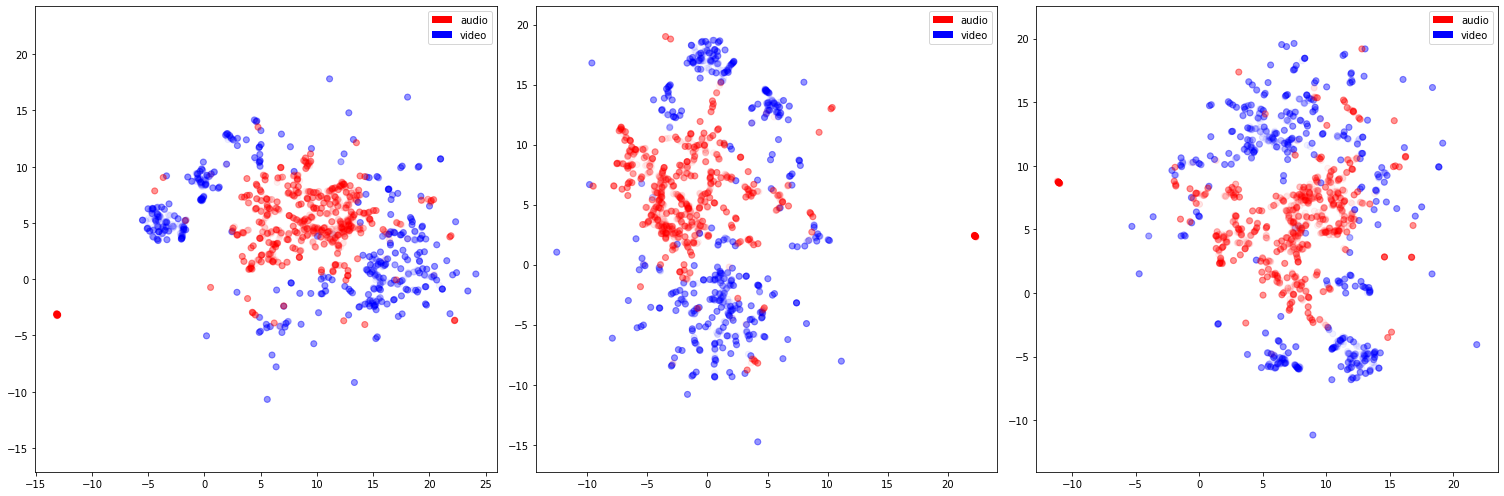

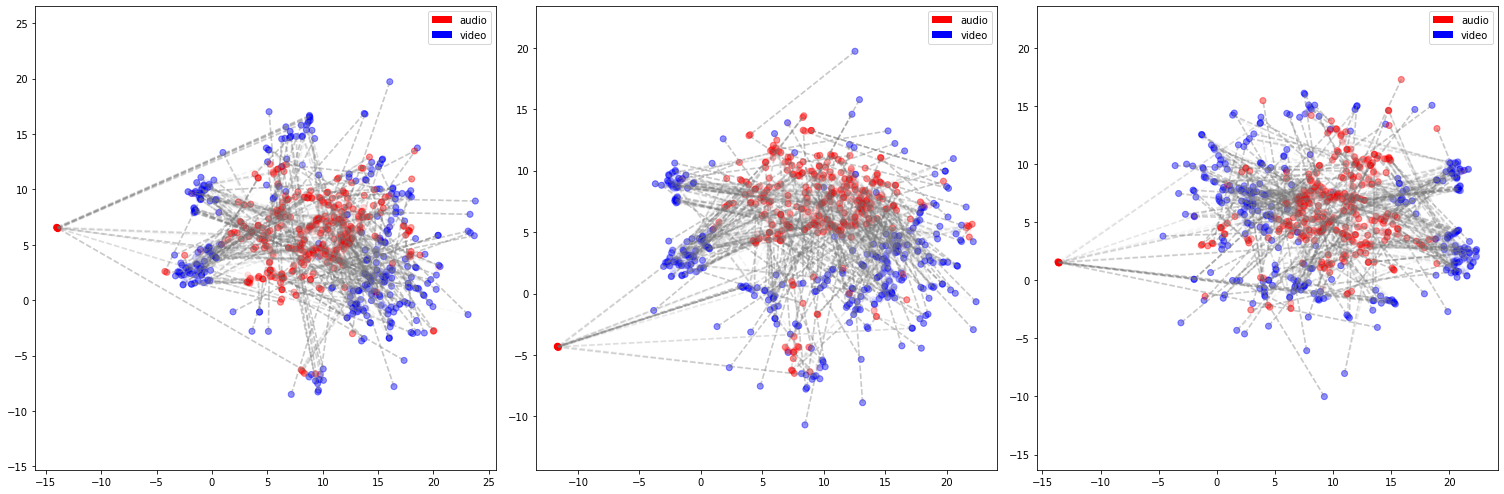

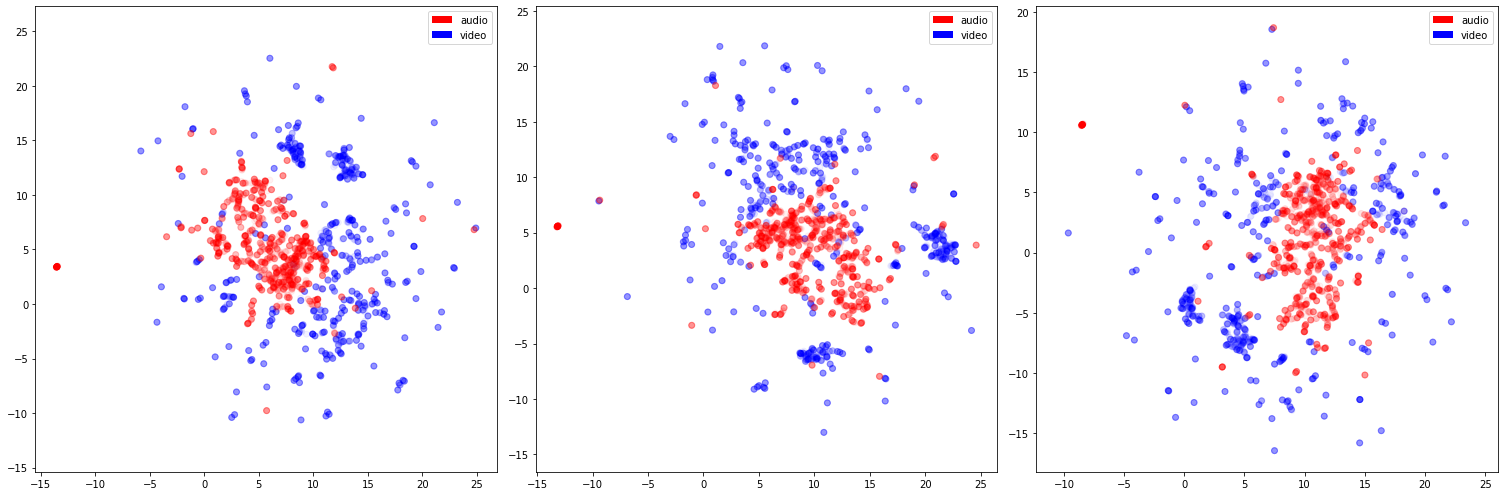

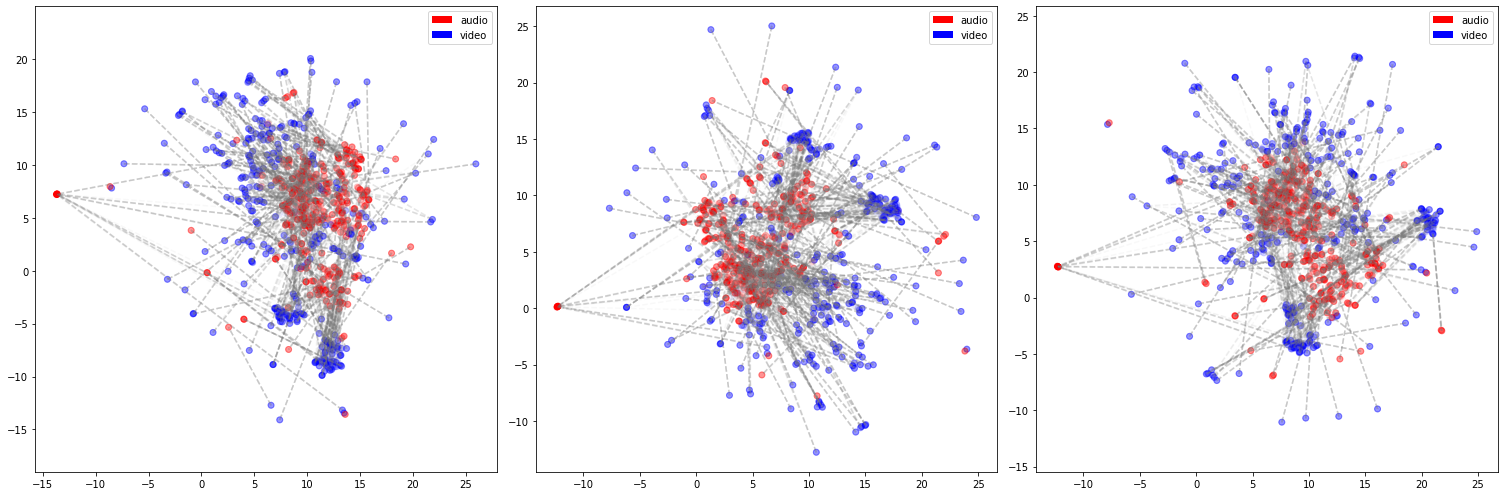

In [7]:
for codings_list, dataset_size in zip([[video_norm, audio_norm], [video_norm_test, audio_norm_test]], [3050, 3170]):
    plt.figure(figsize=(21, 7))
    for i in range(3):
        umap_reducer = umap.UMAP()
        umap_embedding = umap_reducer.fit_transform(np.vstack(codings_list))
        plt.subplot(1, 3, i + 1)
        plt.scatter(
            umap_embedding[:, 0],
            umap_embedding[:, 1],
            c=["blue"] * dataset_size + ["red"] * dataset_size,
            alpha=0.05,
        )
        plt.gca().set_aspect('equal', 'datalim')
        plt.legend(handles=[Patch(facecolor="red", label='audio'), Patch(facecolor="blue", label='video')])
    plt.tight_layout()
    
    
    plt.figure(figsize=(21, 7))
    for i in range(3):
        umap_reducer = umap.UMAP()
        umap_embedding = umap_reducer.fit_transform(np.vstack(codings_list))
        plt.subplot(1, 3, i + 1)
        plt.scatter(
                umap_embedding[:, 0],
                umap_embedding[:, 1],
                c=["blue"] * dataset_size + ["red"] * dataset_size,
                alpha=0.05,
        )
        for i in range(dataset_size):
            x_values = [umap_embedding[i, 0], umap_embedding[i + dataset_size, 0]]
            y_values = [umap_embedding[i, 1], umap_embedding[i + dataset_size, 1]]    
            plt.plot(x_values, y_values, "gray", linestyle="--", alpha=0.05)
        
        plt.gca().set_aspect('equal', 'datalim')
        plt.legend(handles=[Patch(facecolor="red", label='audio'), Patch(facecolor="blue", label='video')])
    plt.tight_layout()

# t-SNE viz

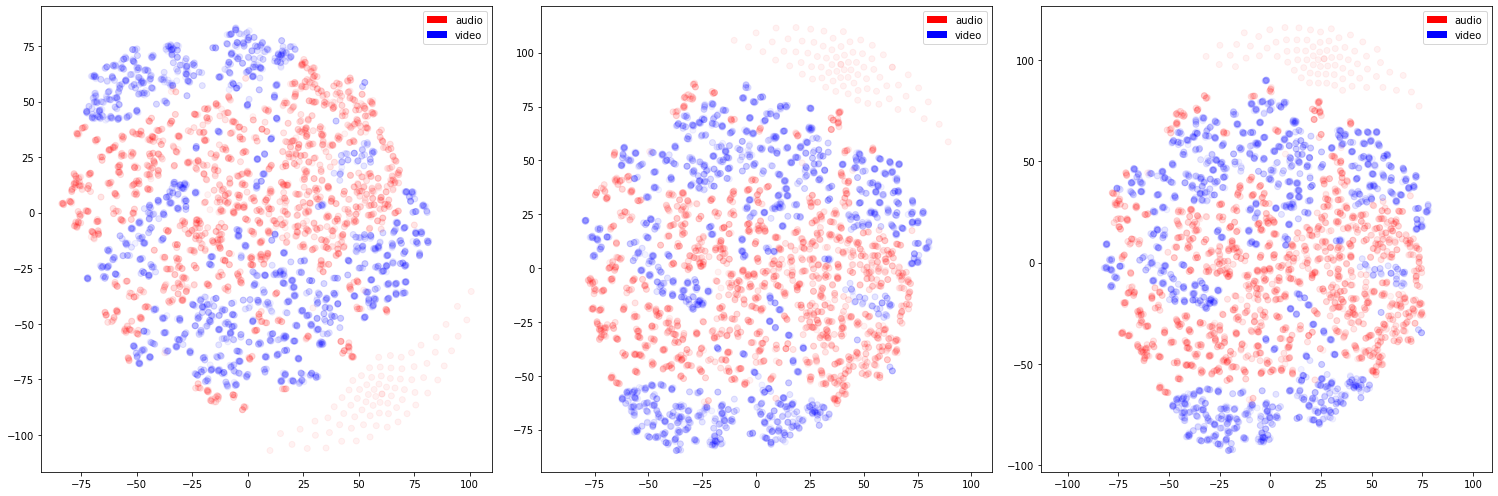

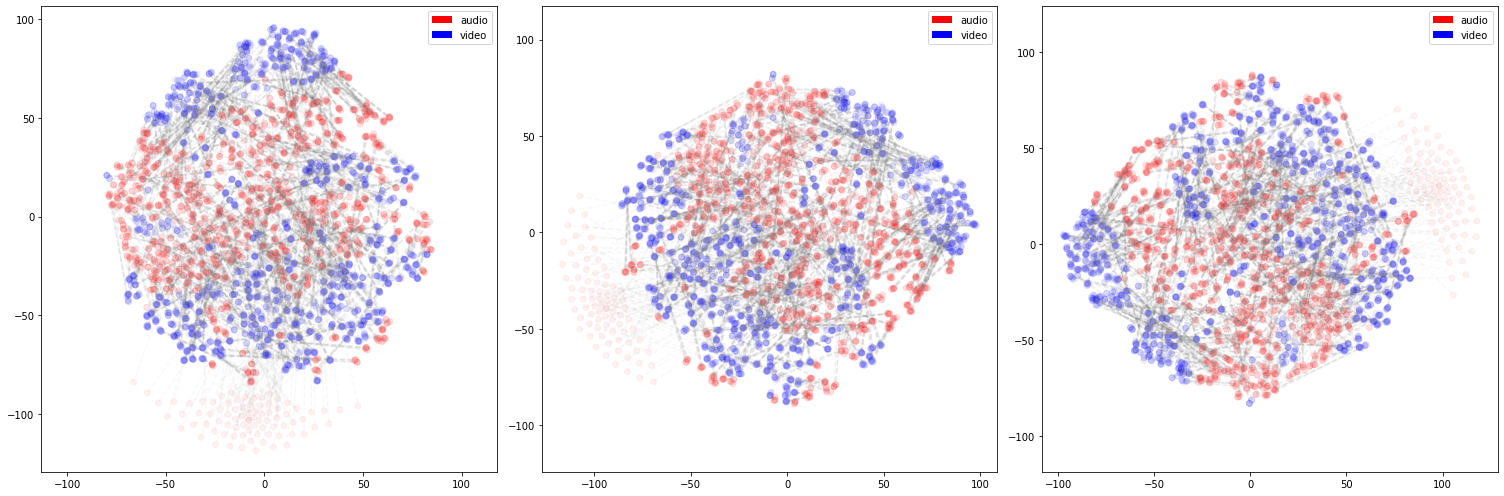

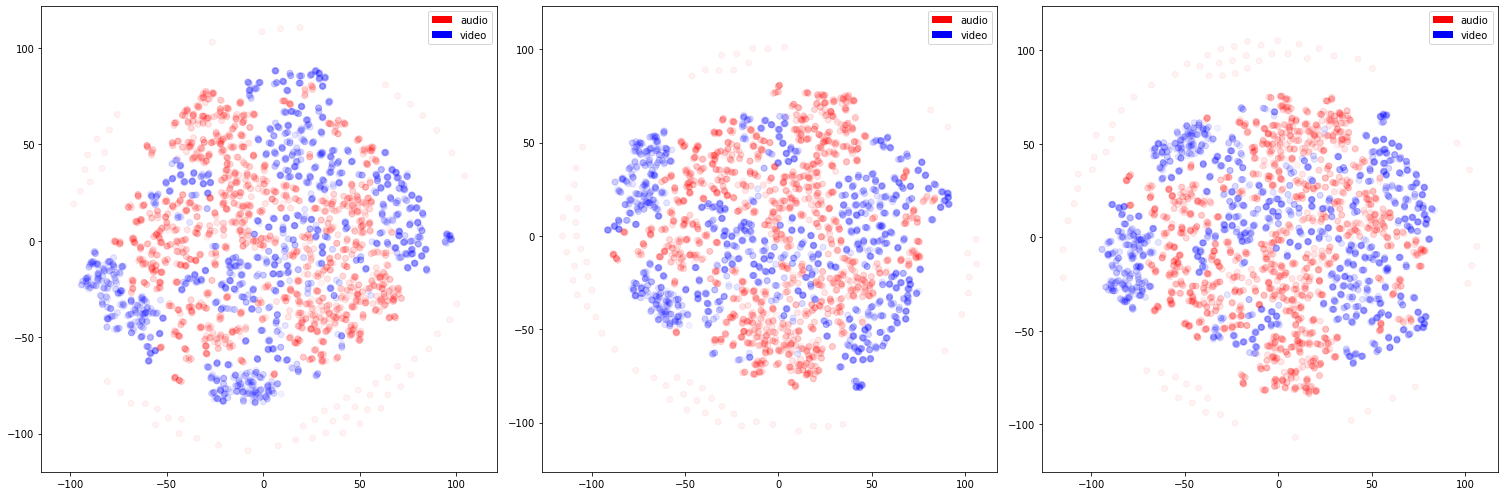

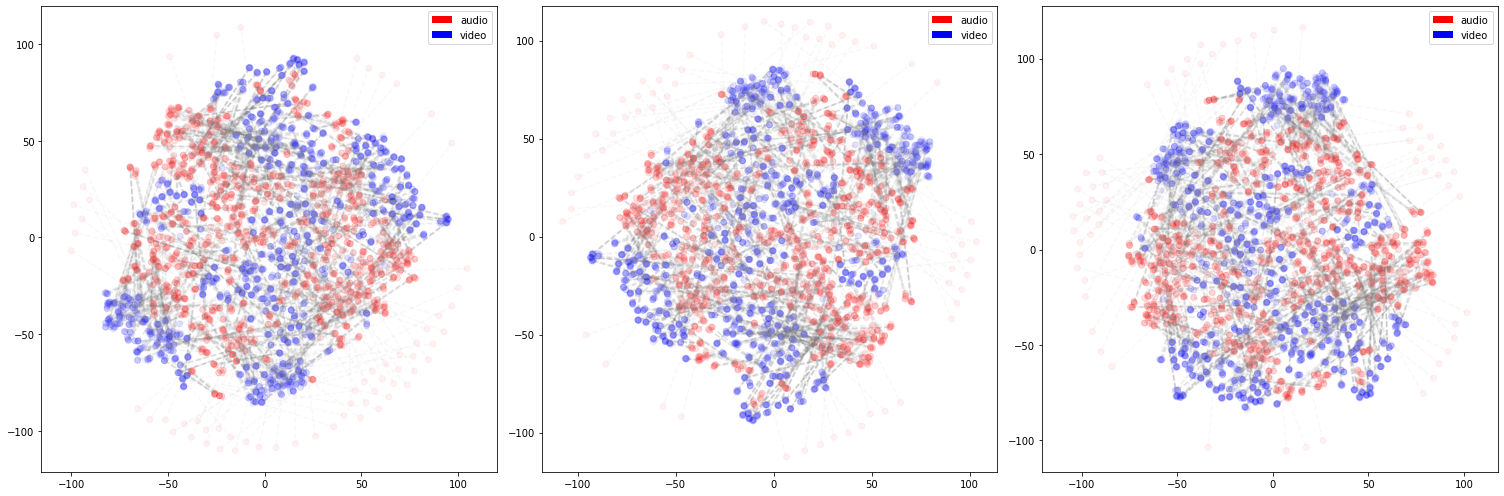

In [8]:
for codings_list, dataset_size in zip([[video_norm, audio_norm], [video_norm_test, audio_norm_test]], [3050, 3170]):
    plt.figure(figsize=(21, 7))
    for i in range(3):
        tsne_reducer = TSNE(n_components=2, learning_rate='auto', init='random')
        tsne_embedding = tsne_reducer.fit_transform(np.vstack(codings_list))
        plt.subplot(1, 3, i + 1)
        plt.scatter(
            tsne_embedding[:, 0],
            tsne_embedding[:, 1],
            c=["blue"] * dataset_size + ["red"] * dataset_size,
            alpha=0.05,
        )
        plt.gca().set_aspect('equal', 'datalim')
        plt.legend(handles=[Patch(facecolor="red", label='audio'), Patch(facecolor="blue", label='video')])
    plt.tight_layout()
    
    
    plt.figure(figsize=(21, 7))
    for i in range(3):
        tsne_reducer = TSNE(n_components=2, learning_rate='auto', init='random')
        tsne_embedding = tsne_reducer.fit_transform(np.vstack(codings_list))
        plt.subplot(1, 3, i + 1)
        plt.scatter(
            tsne_embedding[:, 0],
            tsne_embedding[:, 1],
            c=["blue"] * dataset_size + ["red"] * dataset_size,
            alpha=0.05,
        )
        for i in range(dataset_size):
            x_values = [tsne_embedding[i, 0], tsne_embedding[i + dataset_size, 0]]
            y_values = [tsne_embedding[i, 1], tsne_embedding[i + dataset_size, 1]]    
            plt.plot(x_values, y_values, "gray", linestyle="--", alpha=0.05)
        plt.gca().set_aspect('equal', 'datalim')
        plt.legend(handles=[Patch(facecolor="red", label='audio'), Patch(facecolor="blue", label='video')])
    plt.tight_layout()

# Embedding shift experiment

In [9]:
def shift_embeddings(vid, aud, lambd, gap):
    video_shifted = normalize(vid - lambd * gap, norm="l2")
    audio_shifted = normalize(aud + lambd * gap, norm="l2")
    return video_shifted, audio_shifted
    
def get_gap(vid, aud):
    video_center = vid.mean(axis=0)
    audio_center = aud.mean(axis=0)
    gap = video_center - audio_center
    return np.linalg.norm(gap)

def eval_metrics(codings_val, labels_val, codings_test, labels_test):
    tasks = [
        ["yoga", "tai chi"],
        ["cutting watermelon", "eating watermelon"],
        ["dancing macarena", "robot dancing"],
        ["playing bass guitar", "playing guitar", "strumming guitar", "tapping guitar"],
        ["playing clarinet", "playing flute"],
        ["skiing (not slalom or crosscountry)", "skiing crosscountry", "skiing slalom"],
        ["swimming backstroke", "swimming breast stroke", "swimming butterfly stroke"],
    ]
    output = {}
    for task in tasks:
        output[str(task)] = {}

        val_mask = [l in task for l in labels_val]
        X_val = codings_val[val_mask, :]
        y_val = list(itertools.compress(labels_val, val_mask))
        
        test_mask = [l in task for l in labels_test]
        X_test = codings_test[test_mask, :]
        y_test = list(itertools.compress(labels_test, test_mask))
    
        linreg = LogisticRegression()
        linreg.fit(X_val, y_val)
        preds = linreg.predict_proba(X_test)
            
        output[str(task)]["acc"] = linreg.score(X_test, y_test)
        output[str(task)]["roc"] = roc_auc_score(pd.get_dummies(y_test), preds)
    
    return output

In [10]:
vid_orig = video_norm.copy()
aud_orig = audio_norm.copy()
gap_orig = np.linalg.norm(gap_original)

vid_orig_test = video_norm_test.copy()
aud_orig_test = audio_norm_test.copy()
gap_orig_test = np.linalg.norm(gap_original_test)

lambdas = np.arange(0., 10., 0.01)

In [11]:
results = []
for l in lambdas:
    v_shifted, a_shifted = shift_embeddings(vid_orig, aud_orig, l, gap_orig)
    v_shifted_test, a_shifted_test = shift_embeddings(vid_orig_test, aud_orig_test, l, gap_orig_test)
    gap = get_gap(v_shifted, a_shifted)
    gap_test = get_gap(v_shifted_test, a_shifted_test)

    regression_metrics = eval_metrics(
        codings_val=np.hstack([v_shifted, a_shifted]),
        labels_val=labels,
        codings_test=np.hstack([v_shifted_test, a_shifted_test]),
        labels_test=labels_test
    )
    
    for task, metrics in regression_metrics.items():
        results.append({
            "original_gap": gap_orig,
            "modified_gap": gap,
            "original_gap_test": gap_orig_test,
            "modified_gap_test": gap_test,
            "lambda": l,
            "task": task,
            "acc": metrics["acc"],
            "roc": metrics["roc"],
        })
    
results_df = pd.DataFrame(results)

In [12]:
results_df

,original_gap,modified_gap,original_gap_test,modified_gap_test,lambda,task,acc,roc
0,0.242213,0.242213,0.23189,0.23189,0.00,"['yoga', 'tai chi']",0.807143,0.892456
1,0.242213,0.242213,0.23189,0.23189,0.00,"['cutting watermelon', 'eating watermelon']",0.877419,0.938375
2,0.242213,0.242213,0.23189,0.23189,0.00,"['dancing macarena', 'robot dancing']",0.753125,0.841529
3,0.242213,0.242213,0.23189,0.23189,0.00,"['playing bass guitar', 'playing guitar', 'str...",0.463623,0.699374
4,0.242213,0.242213,0.23189,0.23189,0.00,"['playing clarinet', 'playing flute']",0.744828,0.847304
...,...,...,...,...,...,...,...,...
6995,0.242213,1.998700,0.23189,1.99858,9.99,"['dancing macarena', 'robot dancing']",0.531250,0.854235
6996,0.242213,1.998700,0.23189,1.99858,9.99,"['playing bass guitar', 'playing guitar', 'str...",0.453638,0.720577
6997,0.242213,1.998700,0.23189,1.99858,9.99,"['playing clarinet', 'playing flute']",0.586207,0.797549
6998,0.242213,1.998700,0.23189,1.99858,9.99,"['skiing (not slalom or crosscountry)', 'skiin...",0.557103,0.902987


In [13]:
results_df.groupby("task").apply(lambda df: df.loc[(df.roc == df.roc.max()) | (df.original_gap == df.modified_gap)])

original_gap  \
task                                                                    
['cutting watermelon', 'eating watermelon']        1         0.242213   
['dancing macarena', 'robot dancing']              2         0.242213   
                                                   1402      0.242213   
['playing bass guitar', 'playing guitar', 'stru... 3         0.242213   
                                                   1550      0.242213   
['playing clarinet', 'playing flute']              4         0.242213   
                                                   137       0.242213   
['skiing (not slalom or crosscountry)', 'skiing... 5         0.242213   
                                                   390       0.242213   
['swimming backstroke', 'swimming breast stroke... 6         0.242213   
                                                   1091      0.242213   
['yoga', 'tai chi']                                0         0.242213   
                                                   196       0.242213   

                                                         modified_gap  \
task                                                                    
['cutting watermelon', 'eating watermelon']        1         0.242213   
['dancing macarena', 'robot dancing']              2         0.242213   
                                                   1402      1.968494   
['playing bass guitar', 'playing guitar', 'stru... 3         0.242213   
                                                   1550      1.974069   
['playing clarinet', 'playing flute']              4         0.242213   
                                                   137       0.974057   
['skiing (not slalom or crosscountry)', 'skiing... 5         0.242213   
                                                   390       1.679525   
['swimming backstroke', 'swimming breast stroke... 6         0.242213   
                                                   1091      1.948459   
['yoga', 'tai chi']                                0         0.242213   
                                                   196       1.251472   

                                                         original_gap_test  \
task                                                                         
['cutting watermelon', 'eating watermelon']        1               0.23189   
['dancing macarena', 'robot dancing']              2               0.23189   
                                                   1402            0.23189   
['playing bass guitar', 'playing guitar', 'stru... 3               0.23189   
                                                   1550            0.23189   
['playing clarinet', 'playing flute']              4               0.23189   
                                                   137             0.23189   
['skiing (not slalom or crosscountry)', 'skiing... 5               0.23189   
                                                   390             0.23189   
['swimming backstroke', 'swimming breast stroke... 6               0.23189   
                                                   1091            0.23189   
['yoga', 'tai chi']                                0               0.23189   
                                                   196             0.23189   

                                                         modified_gap_test  \
task                                                                         
['cutting watermelon', 'eating watermelon']        1              0.231890   
['dancing macarena', 'robot dancing']              2              0.231890   
                                                   1402           1.965624   
['playing bass guitar', 'playing guitar', 'stru... 3              0.231890   
                                                   1550           1.971698   
['playing clarinet', 'playing flute']              4              0.231890   
                                                   137            0.93

In [ ]:
# bsz : batch size (number of positive pairs)
# d   : latent dim
# x   : Tensor, shape=[bsz, d]
#       latents for one side of positive pairs
# y   : Tensor, shape=[bsz, d]
#       latents for the other side of positive pairs

def align_loss(x, y, alpha=2):
    return (x - y).norm(p=2, dim=1).pow(alpha).mean()

def uniform_loss(x, t=2):
    return torch.pdist(x, p=2).pow(2).mul(-t).exp().mean().log()